# Water Delineation "proof of concept"

**License:** CC-BY-4.0  
**Github:** [https://github.com/BenjMy/centum](https://github.com/BenjMy/centum)  
**Subject:** Tutorial
**Authors**:

Benjamin Mary
  Email: [benjamin.mary@ica.csic.es](mailto:benjamin.mary@ica.csic.es)  
  ORCID: [0000-0001-7199-2885](https://orcid.org/0000-0001-7199-2885)  
  Affiliation: ICA-CSIC
  
**Date:** 2025/01/10

In [11]:
import numpy as np
import pooch
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
from centum import plotting as pltC
from centum.irrigation_district import IrrigationDistrict 
from centum import irrigation_district as irr_geo_tools 
from centum.delineation import ETAnalysis

## Open datasets

In [3]:
pooch_Majadas = pooch.create(
    path=pooch.os_cache("POC_project"),
    base_url="https://github.com/BenjMy/test_AQUACROP_centum_dataset/raw/refs/heads/main/",
    registry={
        "ds_analysis_EO_0.netcdf": None,
        "ds_analysis_baseline_0.netcdf": None,
    },
)
filename = pooch_Majadas.fetch('ds_analysis_EO_0.netcdf')
ds_analysis_EO = xr.load_dataset(filename)

filename = pooch_Majadas.fetch('ds_analysis_baseline_0.netcdf')
ds_analysis_baselin = xr.load_dataset(filename)

### Show Earth Observation time serie to analyse

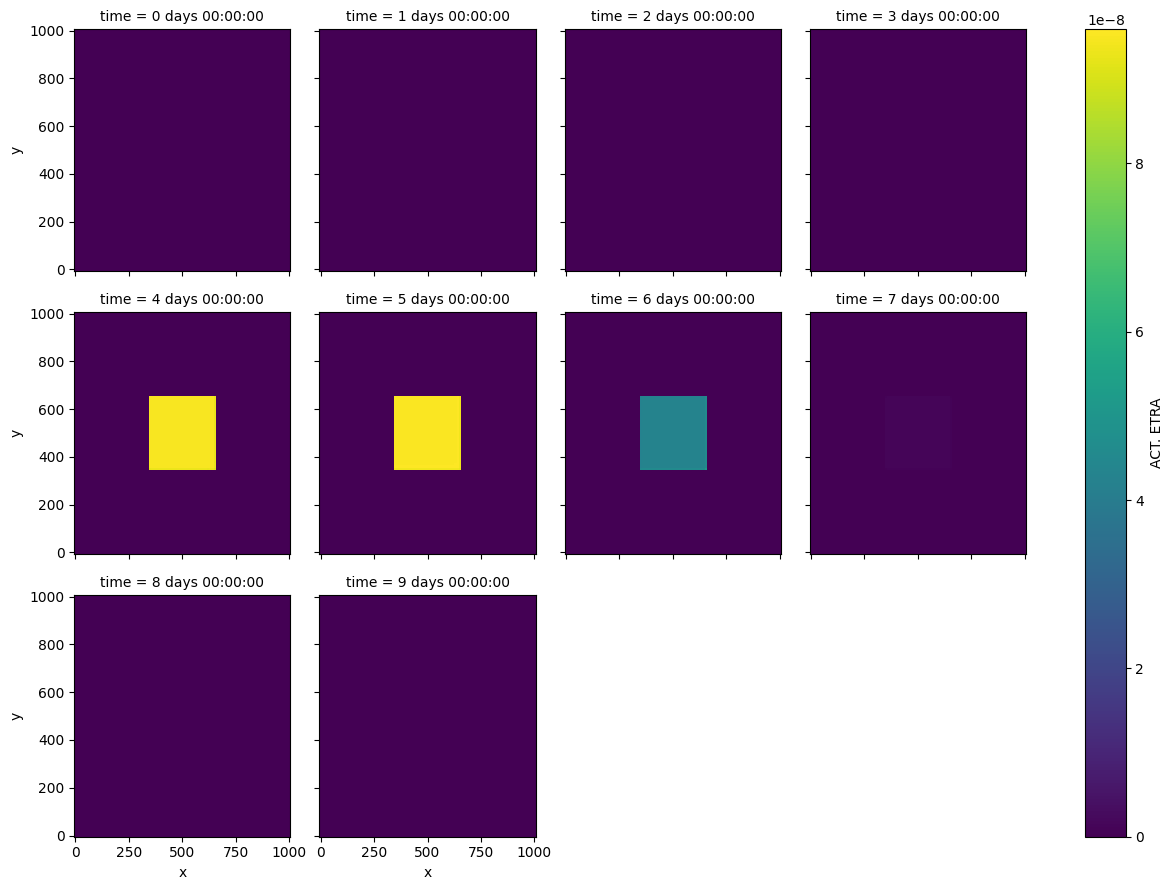

In [5]:
_, index = np.unique(ds_analysis_EO['time'], return_index=True)
ds_analysis_EO = ds_analysis_EO.isel(time=index)

ds_analysis_EO['ACT. ETRA'].plot.imshow(x="x", y="y", 
                                        col="time", 
                                        col_wrap=4,
                                        )

## Irrigation delineation

**Technical Basis of the `irrigation_delineation` Module**

The `irrigation_delineation` module is designed to analyze evapotranspiration (ET) data, compute ratios between actual evapotranspiration (ETa) and potential evapotranspiration (ETp), and classify events (e.g., irrigation, rain). This is achieved through spatial and temporal analysis using **xarray** datasets. Below is a detailed breakdown of the module's functionality.

```{admonition} Steps
- Compute ETa/ETp ratios locally and regionally.
- Identify significant changes in ETa/ETp ratios using thresholds.
- Apply rolling temporal averages to smooth data.
- Classify events as irrigation, rain, or no event based on logical rules.
```

In [6]:
scenario_analysis_usingET = ETAnalysis()
decision_ds, event_type = scenario_analysis_usingET.irrigation_delineation(ds_analysis_EO)

```{hint} Steps
The final `decision_ds` xarray dataset includes:
- Local and regional ETa/ETp ratios.
- Temporal differences of these ratios.
- Boolean thresholds for decision-making.
- Classified events (irrigation, rain, or no event).
```

In [8]:
print(decision_ds)

<xarray.Dataset> Size: 10MB
Dimensions:                                   (time: 9, x: 101, y: 101)
Coordinates:
  * time                                      (time) timedelta64[ns] 72B 1 da...
  * x                                         (x) float64 808B 0.0 ... 1e+03
  * y                                         (y) float64 808B 0.0 ... 1e+03
Data variables: (12/19)
    index                                     (time, x, y) float64 734kB 3.05...
    time_sec                                  (time, x, y) float64 734kB 8.65...
    SURFACE NODE                              (time, x, y) float64 734kB 1.01...
    ACT. ETRA                                 (time, x, y) float64 734kB 0.0 ...
    ETp                                       (time, x, y) float64 734kB -1e-...
    ratio_ETap_local                          (time, x, y) float64 734kB -0.0...
    ...                                        ...
    condRain1                                 (time, x, y) bool 92kB False .....
    condRa

### Plot results of **event detection**

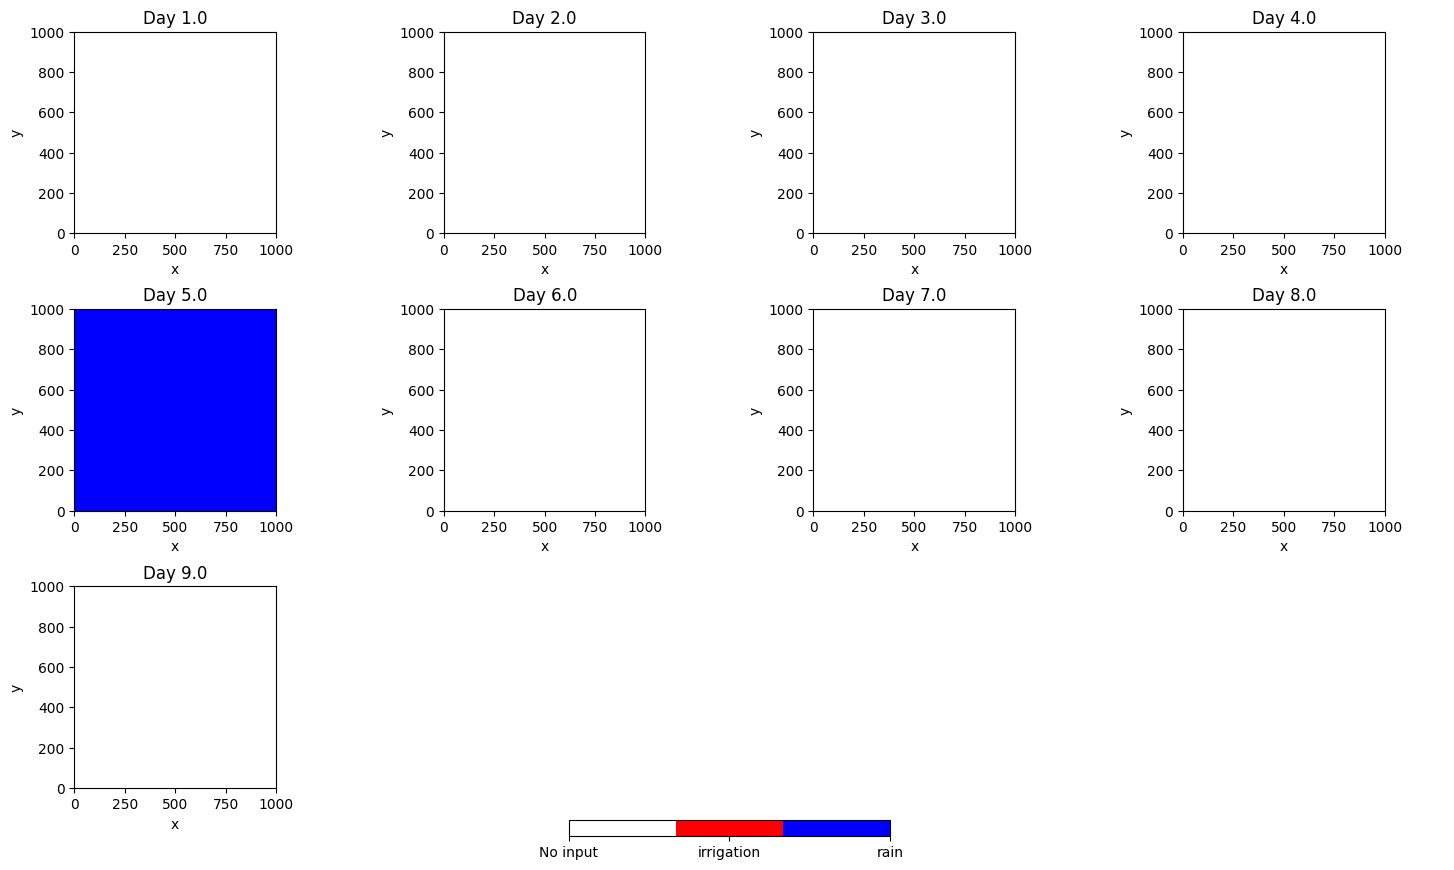

In [12]:
ncols = 4
time_steps = event_type.time.size
nrows = int(np.ceil(time_steps / ncols))  # Number of rows needed
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                         figsize=(15, nrows * 3)
                         )
pltC.plot_irrigation_schedule(event_type,time_steps,fig,axes)

#### Prepare geographic analysis of irrigation districts

In [14]:
GeoAnalysis = IrrigationDistrict("../../data/synthetic/area_SC0.shp")
gdf_irr = GeoAnalysis.load_shapefile()
resolution = event_type.rio.resolution()[0]
bounds = gdf_irr.total_bounds  # (minx, miny, maxx, maxy)
gdf_irr['index'] = gdf_irr.index.values
rioxr_irrigation = GeoAnalysis.convert_to_rioxarray(gdf=gdf_irr, 
                                                    variable="index", 
                                                    resolution=resolution, 
                                                    bounds=bounds
                                                    )
rioxr_irrigation = rioxr_irrigation.rio.write_crs("EPSG:4326")
event_type = event_type.rio.write_crs("EPSG:4326")
rioxr_irrigation= rioxr_irrigation.rio.reproject_match(event_type)


#### Show result for a given district

In [15]:
mask_IN = irr_geo_tools.get_mask_IN_patch_i(rioxr_irrigation,
                                            patchid=1
                                            )
mask_IN = rioxr_irrigation==1
mask_OUT = irr_geo_tools.get_mask_OUT(rioxr_irrigation,
                                      )

event_type_node_IN = event_type.where(mask_IN, drop=True).mean(['x','y'])
event_type_node_OUT = event_type.where(mask_OUT, drop=True).mean(['x','y'])

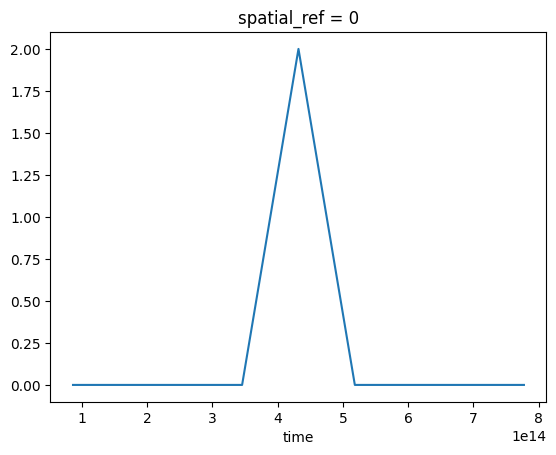

In [16]:
event_type_node_IN.plot()